### In this file I will plot rudimentary results. To see at least a little bit what is going on
In the future I will try to use the provided notebooks in the figure directory

In [18]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from minimodel import data, metrics, model_builder, model_trainer

device = torch.device('cuda')

data_dict = {}

data_path = '../data'
weight_path = './checkpoints_trained'

In [12]:
feve_mice = []
for mouse_id in range (2,6):

    # ------ Data Loading ------

    # load images
    img = data.load_images(data_path, mouse_id, file=data.img_file_name[mouse_id])
    nimg, Ly, Lx = img.shape
    print('img: ', img.shape, img.min(), img.max(), img.dtype)

    # load neurons
    fname = '%s_nat60k_%s.npz'%(data.db[mouse_id]['mname'], data.db[mouse_id]['datexp'])
    spks, istim_train, istim_test, xpos, ypos, spks_rep_all = data.load_neurons(file_path = os.path.join(data_path, fname), mouse_id = mouse_id)
    n_stim, n_max_neurons = spks.shape

    # split train and validation set
    itrain, ival = data.split_train_val(istim_train, train_frac=0.9)

    # normalize spks
    spks, spks_rep_all = data.normalize_spks(spks, spks_rep_all, itrain)

    ineur = np.arange(0, n_max_neurons) #np.arange(0, n_neurons, 5)

    spks_val = torch.from_numpy(spks[ival][:,ineur]) 
    spks_rep_all = [spks_rep_all[i][:,ineur] for i in range(len(spks_rep_all))]

    img_val = torch.from_numpy(img[istim_train][ival]).to(device).unsqueeze(1)
    img_test = torch.from_numpy(img[istim_test]).to(device).unsqueeze(1)

    input_Ly, input_Lx = img_test.shape[-2:]


    # ----- Testing Model Performance ----

    seed = 1
    feve_nlayers = []
    for nlayers in range(1, 5):
        nconv1 = 192
        nconv2 = 192
        model, in_channels = model_builder.build_model(NN=len(ineur), n_layers=nlayers, n_conv=nconv1, n_conv_mid=nconv2)
        model_name = model_builder.create_model_name(data.mouse_names[mouse_id], data.exp_date[mouse_id], n_layers=nlayers, in_channels=in_channels, seed=seed)

        if not os.path.exists(weight_path):
            os.makedirs(weight_path)
        model_path = os.path.join(weight_path, model_name)
        print('model path: ', model_path)
        model = model.to(device)
        model.load_state_dict(torch.load(model_path))
        print('loaded model', model_path)

        # test model
        test_pred = model_trainer.test_epoch(model, img_test)
        test_fev, test_feve = metrics.feve(spks_rep_all, test_pred)
        print('FEVE (test, all): ', np.mean(test_feve))

        threshold = 0.15
        print(f'filtering neurons with FEV > {threshold}')
        valid_idxes = np.where(test_fev > threshold)[0]
        print(f'valid neurons: {len(valid_idxes)} / {len(test_fev)}')
        print(f'FEVE (test, FEV>0.15): {np.mean(test_feve[test_fev > threshold])}')

        feve_nlayers.append(np.mean(test_feve[test_fev > threshold]))

    feve_mice.append(feve_nlayers)

raw image shape:  (68000, 66, 264)
cropped image shape:  (68000, 66, 130)
img:  (68000, 66, 130) -2.062947 2.088608 float32
img:  (68000, 66, 130) -2.062947 2.088608 float32

loading activities from ../data/FX9_nat60k_2023_05_15.npz

splitting training and validation set...
itrain:  (32662,)
ival:  (3630,)

normalizing neural data...
finished
core shape:  torch.Size([1, 192, 33, 65])
input shape of readout:  (192, 33, 65)
model name:  FX9_051523_1layer_192_clamp_norm_depthsep_pool.pt
model path:  ./checkpoints_trained/FX9_051523_1layer_192_clamp_norm_depthsep_pool.pt
loaded model ./checkpoints_trained/FX9_051523_1layer_192_clamp_norm_depthsep_pool.pt
FEVE (test, all):  0.47606018
filtering neurons with FEV > 0.15
valid neurons: 926 / 3575
FEVE (test, FEV>0.15): 0.5868911743164062
core shape:  torch.Size([1, 192, 33, 65])
input shape of readout:  (192, 33, 65)
model name:  FX9_051523_2layer_192_192_clamp_norm_depthsep_pool.pt
model path:  ./checkpoints_trained/FX9_051523_2layer_192_192_

In [13]:
feve_mice = np.array(feve_mice)
print(feve_mice)

[[0.5868912  0.7208451  0.74744856 0.7462293 ]
 [0.5690163  0.6754321  0.7133087  0.7174059 ]
 [0.55430263 0.6746317  0.7015465  0.7174382 ]
 [0.6027293  0.7071793  0.7392756  0.7455187 ]]


mean: [0.57823485 0.6945221  0.72539485 0.731648  ]
sem: [0.0105382  0.0115944  0.01077752 0.00821465]


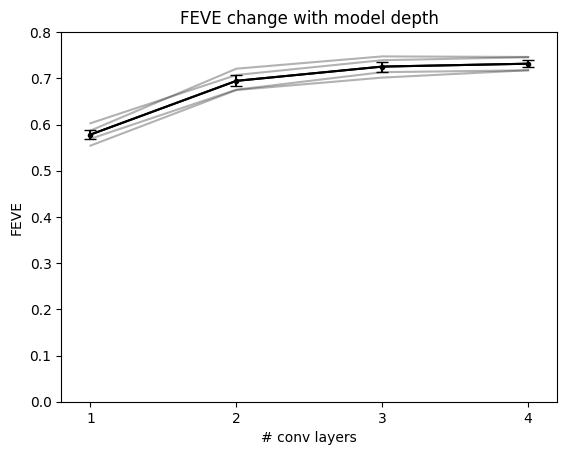

In [45]:
mean = np.mean(feve_mice, axis=0)
sem = np.std(feve_mice, axis=0, ddof=1) / np.sqrt(feve_mice.shape[0])
print(f"mean: {mean}")
print(f"sem: {sem}")

x = [1,2,3,4]

for mice_id in range(0,4):
    plt.plot(x, feve_mice[mice_id], color="BLACK", alpha=0.3)

plt.plot(x, mean, marker="o", markersize= 3, color="BLACK")
plt.errorbar(
    x,
    mean,
    yerr=sem,
    capsize=4,
    color = "BLACK"
)


plt.ylabel("FEVE")
plt.xlabel("# conv layers")
plt.title("FEVE change with model depth")

plt.xlim(0.8,4.2)
plt.xticks([1,2,3,4])
plt.ylim(0.0, 0.8)


plt.show()